In [1]:
import copy

import numpy as np

import cytoxnet.models.models
import cytoxnet.dataprep.io
import cytoxnet.dataprep.featurize
import cytoxnet.dataprep.dataprep
import importlib
import matplotlib.pyplot as plt

# Ivestigate transfering data across datasets

## get and prepare data

Get data

In [109]:
## loading a dataset
data_raw = cytoxnet.dataprep.io.load_lunghini(nans='keep')
data_raw.describe()

,algea_EC50,fish_LC50,daphnia_EC50
count,1440.000000,2199.000000,2120.000000
mean,118.942882,202.975335,62.426641
std,596.983371,1308.709203,632.706477
min,0.000395,0.000130,0.000000
25%,3.200000,1.800000,1.000000
50%,15.000000,9.400000,6.455000
75%,56.325000,52.000000,31.075000
max,9120.000000,37700.000000,25000.000000


Take the log

In [110]:
def log_trans(row):
    inp = row.values.reshape(-1)
    out = []
    for val in inp:
        if not np.isnan(val):
            val_ = np.log(val)
            if np.isinf(val_):
                out.append(np.nan)
            else:
                out.append(val_)
        else:
            out.append(val)
    return out

In [111]:
data_raw[['algea_EC50', 'fish_LC50', 'daphnia_EC50']] = data_raw[['algea_EC50', 'fish_LC50', 'daphnia_EC50']].apply(log_trans)

/Users/ek/miniconda3/envs/cytoxnet/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


In [112]:
data_raw[np.isinf(data_raw_[['algea_EC50', 'fish_LC50', 'daphnia_EC50']].values)]

,smiles,algea_EC50,fish_LC50,daphnia_EC50
393,CC(C)=CC1C(C(=O)OC(C#N)c2cccc(Oc3ccccc3)c2)C1(C)C,NaN,-7.929542,NaN
729,CC1(C)C(C(=O)OC(C#N)c2cccc(Oc3ccccc3)c2)C1(C)C,NaN,-6.061745,NaN
1722,CCOP(=O)(NC(C)C)Oc1ccc(SC)c(C)c1,NaN,-4.111694,NaN
1731,CCOP(=S)(NC(C)C)Oc1ccccc1C(=O)OC(C)C,NaN,0.559616,NaN
1741,CCOP(=S)(OCC)Oc1ccc2c(C)c(Cl)c(=O)oc2c1,NaN,-0.116534,NaN
1746,CCOP(=S)(OCC)SCSP(=S)(OCC)OCC,NaN,-0.335447,NaN
1930,CN(c1c(Br)cc(Br)cc1Br)c1c(cc(cc1C(F)(F)F)[N+](...,NaN,-0.578034,NaN
2130,COP(=O)(OC)OC(=CCl)c1cc(Cl)c(Cl)cc1Cl,NaN,-0.636767,NaN
2141,COP(=S)(OC)Oc1ccc(Sc2ccc(OP(=S)(OC)OC)cc2)cc1,NaN,NaN,NaN
2147,COP(=S)(OC)Oc1nc(Cl)c(Cl)cc1Cl,NaN,-1.200645,NaN


Add features

In [113]:
data_all = cytoxnet.dataprep.featurize.molstr_to_Mol(data_raw, 'smiles')
data_all = cytoxnet.dataprep.featurize.add_features(data_all, method='ConvMolFeaturizer')

Pop some algea examples to act as a global test set

In [114]:
dataframe_algea_test = data_all[~data_all['algea_EC50'].isnull()].sample(frac=0.2)
dataframe_all_dev = data_all.drop(dataframe_algea_test.index, axis=0)

Make add weights for sparsity data

In [115]:
dataframe_all_dev['w'] = list(np.float64(
        ~dataframe_all_dev[['algea_EC50', 'fish_LC50', 'daphnia_EC50']].isnull().values
    )
)
dataframe_algea_test['w'] = list(np.float64(
        ~dataframe_algea_test[['algea_EC50', 'fish_LC50', 'daphnia_EC50']].isnull().values
    )
)

Create some deepchem datasets to use

In [116]:
# algea global test set
algea_test = cytoxnet.dataprep.dataprep.convert_to_dataset(
    dataframe_algea_test,
    X_col = ['ConvMolFeaturizer'],
    y_col = 'algea_EC50'
)
# need this test set with all 3 tasks for multitask
dataframe_algea_test_ = dataframe_algea_test.fillna(0.0)
algea_test_multi = cytoxnet.dataprep.dataprep.convert_to_dataset(
    dataframe_algea_test_,
    X_col = ['ConvMolFeaturizer'],
    y_col = ['algea_EC50', 'fish_LC50', 'daphnia_EC50'],
    w_col = 'w'
)
# algea train set - the algea indexes in the dev set
algea_train = cytoxnet.dataprep.dataprep.convert_to_dataset(
    dataframe_all_dev[~dataframe_all_dev['algea_EC50'].isnull()],
    X_col = ['ConvMolFeaturizer'],
    y_col = 'algea_EC50'
)
# a fish dataset
fish_train = cytoxnet.dataprep.dataprep.convert_to_dataset(
    dataframe_all_dev[~dataframe_all_dev['fish_LC50'].isnull()],
    X_col = ['ConvMolFeaturizer'],
    y_col = 'fish_LC50'
)
# a multitasker of all but the algea test
# first replace nans
dataframe_all_dev_ = dataframe_all_dev.fillna(0.0)
multi_train = cytoxnet.dataprep.dataprep.convert_to_dataset(
    dataframe_all_dev_,
    X_col = ['ConvMolFeaturizer'],
    y_col = ['algea_EC50', 'fish_LC50', 'daphnia_EC50'],
    w_col = 'w'
)

## Train a baseline model on just algea data

In [118]:
baseline = cytoxnet.models.models.ToxModel(
    'GraphCNN', 
    mode='regression')

Let's use 150 epochs as a baseline.

In [119]:
train_losses = []
test_losses = []
for iteration in range(15):
    train_losses.append(baseline.fit(algea_train, nb_epoch=10))
    test_losses.append(baseline.fit(algea_test, checkpoint_interval=0))
    baseline.model.restore()

/Users/ek/miniconda3/envs/cytoxnet/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_10/graph_pool_21/Reshape_14:0", shape=(310,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model_10/graph_pool_21/Reshape_13:0", shape=(310, 64), dtype=float32), dense_shape=Tensor("gradient_tape/private__graph_conv_keras_model_10/graph_pool_21/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/Users/ek/miniconda3/envs/cytoxnet/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_10/graph_pool_21/Reshape_17:0", shape=(1278,), dtype=int32), values=Tensor("gradi

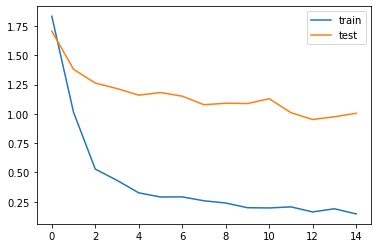

In [120]:
fig, ax = plt.subplots()
ax.plot(train_losses, label='train')
ax.plot(test_losses, label='test')
plt.legend()

In [121]:
baseline.evaluate(algea_test, metrics=['r2_score'])

{'metric-1': 0.4275586555237795}

In [122]:
baseline.visualize('pair_predict', algea_test, untransform=False)

(288, 1)


alt.LayerChart(...)

## Lets try a raw transfer from fish data
This involves no layer fixing - just retrain on a new dataset.

In [135]:
fish_pretrain = cytoxnet.models.models.ToxModel(
    'GraphCNN', 
    mode='regression')

Pretrain on fish data 300 epochs

In [136]:
train_losses = []
test_losses = []
for iteration in range(30):
    train_losses.append(fish_pretrain.fit(fish_train, nb_epoch=10))
    test_losses.append(fish_pretrain.fit(algea_test, checkpoint_interval=0))
    baseline.model.restore()

/Users/ek/miniconda3/envs/cytoxnet/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_13/graph_pool_27/Reshape_14:0", shape=(378,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model_13/graph_pool_27/Reshape_13:0", shape=(378, 64), dtype=float32), dense_shape=Tensor("gradient_tape/private__graph_conv_keras_model_13/graph_pool_27/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/Users/ek/miniconda3/envs/cytoxnet/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_13/graph_pool_27/Reshape_17:0", shape=(1270,), dtype=int32), values=Tensor("gradi

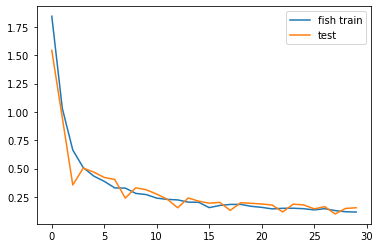

In [137]:
fig, ax = plt.subplots()
ax.plot(train_losses, label='fish train')
ax.plot(test_losses, label='test')
plt.legend()

Transfer to algea and monitor loss

In [138]:
train_losses = []
test_losses = []
for iteration in range(15):
    train_losses.append(fish_pretrain.fit(algea_train, nb_epoch=10))
    test_losses.append(fish_pretrain.fit(algea_test, checkpoint_interval=0))
    baseline.model.restore()

In [ ]:
fig, ax = plt.subplots()
ax.plot(train_losses, label='algea train')
ax.plot(test_losses, label='test')
plt.legend()

In [ ]:
fish_pretrain.evaluate(algea_test, metrics=['r2_score'])

In [ ]:
fish_pretrain.visualize('pair_predict', algea_test, untransform=False)

## Try a sparse multitask predictor and see how well it does on algea

In [ ]:
multitask_model = cytoxnet.models.models.ToxModel(
    'GraphCNN', 
    mode='regression',
    tasks=['algea_EC50', 'fish_LC50', 'daphnia_EC50']
)

In [ ]:
multitask_model.fit(multi_train, nb_epoch=5)

In [ ]:
multitask_model.predict(multi_train)

In [ ]:
multitask_model.evaluate(algea_test_multi,
                         metrics=['r2_score'],
                         per_task_metrics=True,
                         use_sample_weights=True)

In [ ]:
multitask_model.visualize('pair_predict', algea_test_multi, untransform=False, task='algea_EC50')